# Gentle introduction to Pytorch Functional

You don't need any knowledge of the inner workings of Pytorch Functional to use it.

In most cases, after seeing a few examples, you're good to go.

If you used Keras Functional API before, you don't even need any learning materials.

However, this notebooks explains Pytorch Functional a little bit deeper, in case you just want to know more stuff.

In [1]:
!pip install pytorch-functional networkx matplotlib scipy tqdm

In [2]:
import torch
from torch import nn
from pytorch_functional import FunctionalModel, Input, layers

from pytorch_functional.tools import draw_computation_graph
import matplotlib.pyplot as plt

import torchvision
from tqdm.notebook import tqdm

## Having fun with symbolic tensors
### Simple example
We'll first look at what we can do with symbolic tensors.

In [3]:
x = Input(shape=(5,))
y = Input(shape=(5,))
print(f"x={x}")
print(f"y={y}")
print()

z = x + y
print("After creating z = x + y:")
print(f"x={x}")
print(f"y={y}")
print(f"z={z}")

x=<SymbolicTensor at 0x7f021775e820; child of 0; parent of 0>
y=<SymbolicTensor at 0x7f021775e970; child of 0; parent of 0>

After creating z = x + y:
x=<SymbolicTensor at 0x7f021775e820; child of 0; parent of 1>
y=<SymbolicTensor at 0x7f021775e970; child of 0; parent of 1>
z=<SymbolicTensor at 0x7f02bcf4c4f0; child of 2; parent of 0>


We created two symbolic tensors: `x` and `y`.
Their sum is represented by another symbolic tensor: `z`, which was added to the graph of computations.

When we print the tensors, we can see that `z` has two parents and both `x` and `y` have one child.

If we need, we can even retrieve the instances of specific children and parents.

As it is in life, you cannot change your parents, thus `.parents` are immutable. But `.children` are not!

In [4]:
print(f"x.children={x.children}")
print(f"y.children={y.children}")

print(f"z.parents={z.parents}")

x.children=[<SymbolicTensor at 0x7f02bcf4c4f0; child of 2; parent of 0>]
y.children=[<SymbolicTensor at 0x7f02bcf4c4f0; child of 2; parent of 0>]
z.parents=(<SymbolicTensor at 0x7f021775e820; child of 0; parent of 1>, <SymbolicTensor at 0x7f021775e970; child of 0; parent of 1>)


We are creating full fledged graphs now! Let's try to plot them...

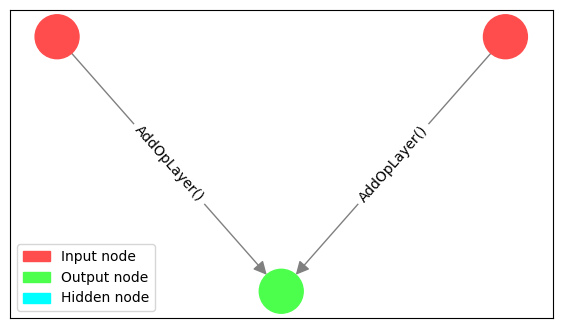

In [5]:
plt.figure(figsize=(7, 4))
draw_computation_graph(inputs=(x, y), node_text_func=lambda x: "")

We can see that addition was converted to `AddOpLayer`.

If we want to use a custom operator or function on a symbolic tensor, we need to create an nn.Module.

For simple operators like addition, Pytorch Functional will do it for us automatically!

### A deeper example

We will create another, more complicated model.

Still no neural networks, but we'll get to them, I promise!

In [6]:
x = Input(shape=())
y = Input(shape=())
intermediate_values = [
    x + y,
    x - y,
    x * y,
]
outputs = sum(intermediate_values) / 3

In [7]:
intermediate_values

[<SymbolicTensor at 0x7f021775e2b0; child of 2; parent of 1>,
 <SymbolicTensor at 0x7f021776cc70; child of 2; parent of 1>,
 <SymbolicTensor at 0x7f01e36fadf0; child of 2; parent of 1>]

We can see that the three intermediate values are children of 2 nodes and parent for 1 node.

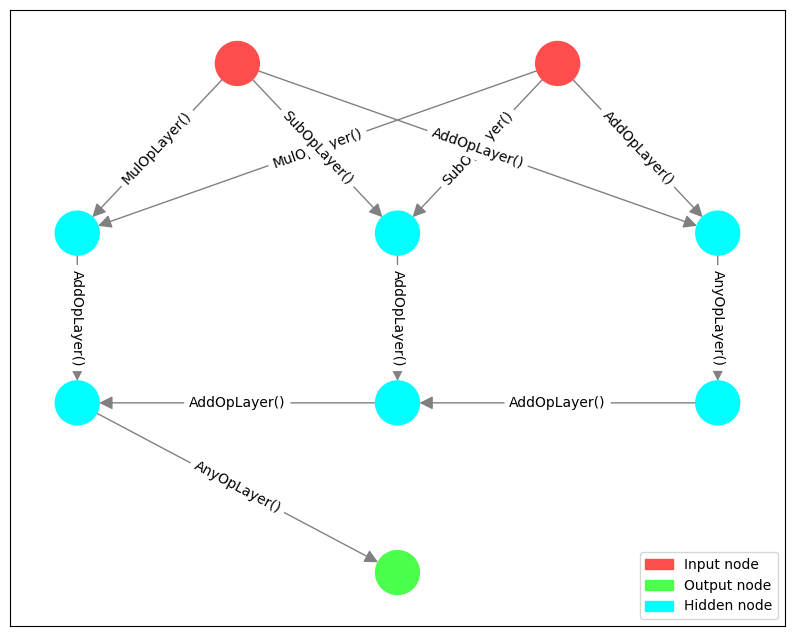

In [8]:
plt.figure(figsize=(10, 8))
gr = draw_computation_graph(inputs=(x, y), node_text_func=lambda x: "")

Moreover, we see what Python does internally, when `sum` is called. It's just a bunch of additions! Obviously...

Let us create a Functional Model from this graph!

In [9]:
model = FunctionalModel(inputs=(x, y), outputs=outputs)
model

FunctionalModel(
  (module000_depth001): AddOpLayer()
  (module001_depth002): AnyOpLayer()
  (module002_depth002): AddOpLayer()
  (module003_depth002): AddOpLayer()
  (module004_depth003): AnyOpLayer()
  (module005_depth001): SubOpLayer()
  (module006_depth001): MulOpLayer()
)

In [10]:
rx = torch.rand(
    1,
)
ry = torch.rand(
    1,
)

print(f"rx={rx}")
print(f"ry={ry}")
print(f"model(rx, ry)={model(rx, ry)}")

assert model(rx, ry) == ((rx + ry) + (rx - ry) + (rx * ry)) / 3, "Something went wrong..."

rx=tensor([0.0662])
ry=tensor([0.1491])
model(rx, ry)=tensor([0.0475])


As we see, after defining the model on symbolic tensors, it works perfectly fine when launched on real data!

Right now, we were manipulating the data with `+`, `-` and `*` operators.

Most of Python's operators are already defined for symbolic tensors, e.g.: `+, -, *, /, //, %, abs`.

They will be converted to ``nn.Module`` and registered correctly in the model.

## Symbolic tensors && real layers

However, in deep learning, we rarely use just standard operations. Instead, we rely on layers to transform the data.
Let's create a small linear model with a few hidden layers!

In [11]:
inputs = x = Input((4,))
x = nn.Linear(x.features, 10)(x)
x = nn.Linear(x.features, 10)(x)
x = nn.Linear(x.features, 10)(x)
outputs = nn.Linear(x.features, 1)(x)

model = FunctionalModel(inputs, outputs)
model

FunctionalModel(
  (module000_depth001): Linear(in_features=4, out_features=10, bias=True)
  (module001_depth002): Linear(in_features=10, out_features=10, bias=True)
  (module002_depth003): Linear(in_features=10, out_features=10, bias=True)
  (module003_depth004): Linear(in_features=10, out_features=1, bias=True)
)

Looks like it was a succes. Let's see how it looks like as a graph!

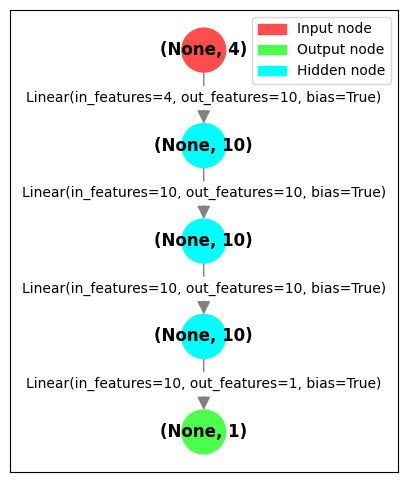

In [12]:
plt.figure(figsize=(5, 6))
draw_computation_graph(model=model, rotate=False)

It's a rather simple topology.

### An odd one

We'll now create a model that consists of a few towers - separate functional models.

It means we will use functional model inside another functional model. Cool, isn't it?

There'll be:
* 3 separete inputs
* 2 outputs

After a few layers of separated computations, the results will be concatenated, then transformed some more and returned!

In [13]:
def get_tower(height):
    inputs = x = Input((5,))
    for _ in range(height):
        x = nn.Linear(x.features, 10)(x)
    model = FunctionalModel(inputs, x)
    return model


towers = [get_tower(height=5 + i) for i in range(3)]
inputs = [Input((5,)) for _ in range(3)]
outputs = []

for x, tower in zip(inputs, towers):
    outputs.append(tower(x))

x = layers.ConcatLayer(dim=1)(*outputs)

out1 = nn.Linear(x.features, 5)(x)
out2 = nn.Linear(x.features, 3)(x)

model = FunctionalModel(inputs, (out1, out2))

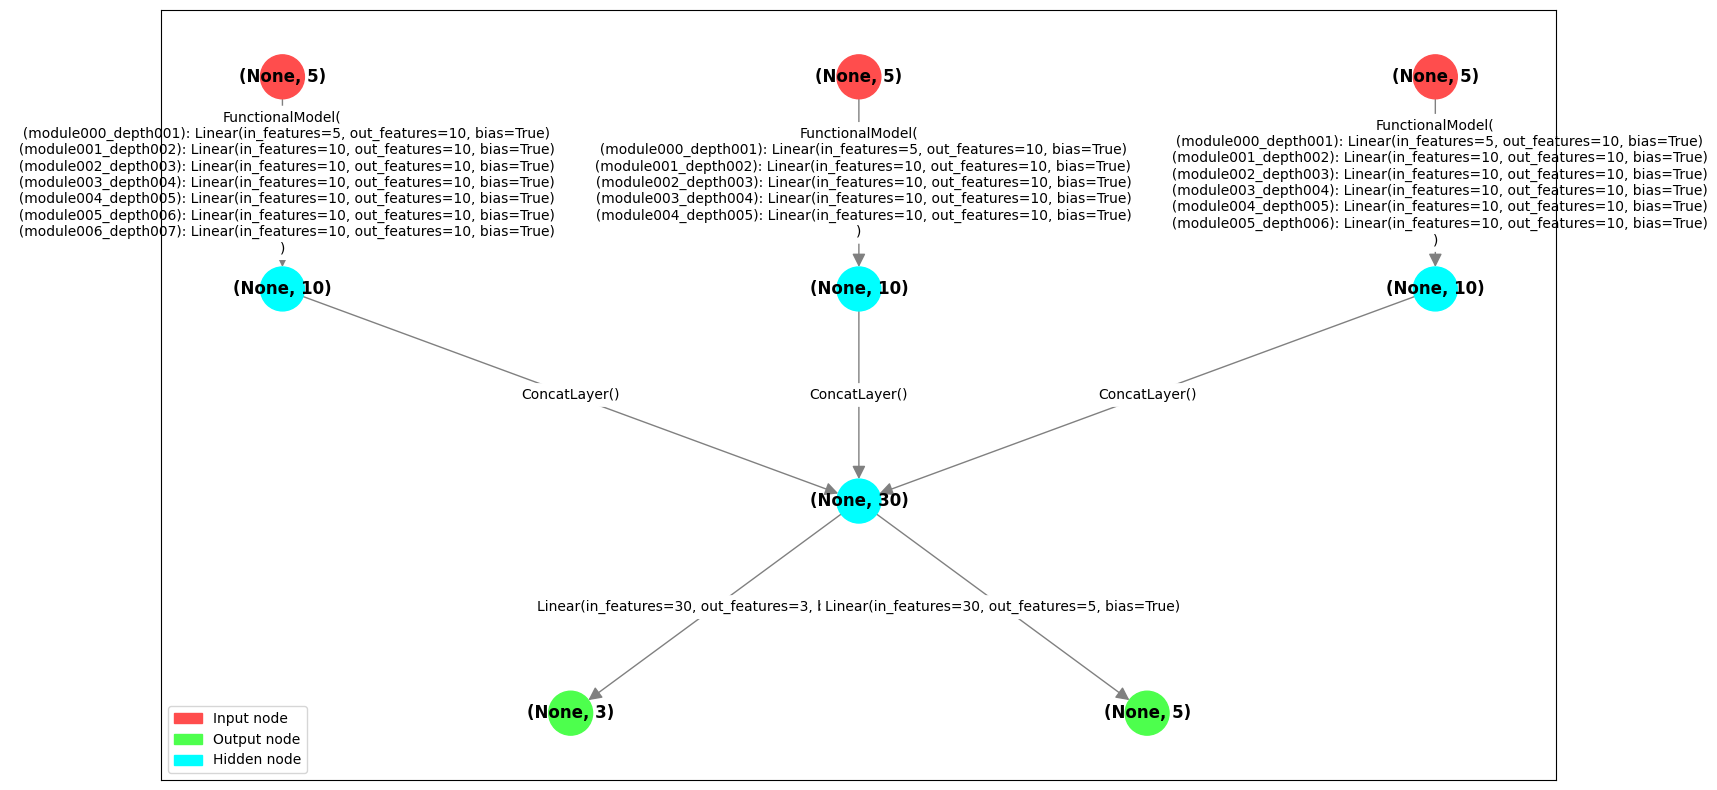

In [14]:
plt.figure(figsize=(18, 10))

draw_computation_graph(model=model, rotate=False)

Although this graph drawing solution is not ideal, it might be just enough to demonstrate the concept.

You can use it if you have optional dependencies are installed:

* matplotlib
* networkx
* scipy

Then import `from pytorch_functional.tools import draw_computation_graph`.

You can find the reference [in the Docs](https://pytorch-functional.readthedocs.io/en/latest/Reference/tools/).

## Functional API in real models

Let us create and train a small ResNet example that will work on MNIST dataset.

To train the model quickly, you need to have CUDA capable device.

On Colab, be sure to set "Hardware accelerator" to "GPU".

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [16]:
# Creating dataset

ds = torchvision.datasets.MNIST(root=".", download=True, transform=torchvision.transforms.ToTensor())
train, valid = torch.utils.data.random_split(ds, [50000, 10000])

train_dl = torch.utils.data.DataLoader(
    train, batch_size=100, shuffle=True, drop_last=True, pin_memory=True, num_workers=1
)
valid_dl = torch.utils.data.DataLoader(
    valid, batch_size=100, shuffle=False, drop_last=True, pin_memory=True, num_workers=1
)

In [17]:
def create_model():
    def shortcut_func(x, channels, stride):
        if x.channels != channels or stride != 1:
            return x(nn.Conv2d(x.channels, channels, kernel_size=1, bias=False, stride=stride))
        else:
            return x

    inputs = Input(batch_shape=(100, 1, 28, 28))
    flow = inputs(nn.Conv2d(inputs.channels, 16, 3, padding=1))

    for group_size, width, stride in [(2, 16, 1), (2, 32, 2), (2, 64, 2)]:
        for _ in range(group_size):
            shortcut = shortcut_func(flow, width, stride)

            flow = nn.BatchNorm2d(flow.channels)(flow)(nn.ReLU())
            flow = nn.Conv2d(flow.channels, width, 3, stride, 1)(flow)
            flow = nn.BatchNorm2d(flow.channels)(flow)(nn.ReLU())
            flow = nn.Conv2d(flow.channels, width, 3, 1, 1)(flow)

            flow = flow + shortcut
            stride = 1

    flow = nn.BatchNorm2d(flow.channels)(flow)(nn.ReLU())
    flow = nn.MaxPool2d(kernel_size=flow.HW)(flow)(nn.Flatten())
    outs = nn.Linear(flow.features, 10)(flow)
    return inputs, outs


inputs, outputs = create_model()
model = FunctionalModel(inputs=inputs, outputs=outputs).to(device)
optimizer = torch.optim.Adam(model.parameters())

In [18]:
def traininig(model, optimizer, epochs):
    model.train()

    loss_fn = nn.CrossEntropyLoss()

    for epoch in tqdm(range(epochs)):
        mean_acc = 0
        mean_acc_n = 0

        for x, y in train_dl:
            x = x.to(device)
            y = y.to(device)

            model.zero_grad()
            outs = model(x)

            loss = loss_fn(outs, y)
            loss.backward()
            optimizer.step()

            accuracy = torch.mean((outs.argmax(1) == y).to(torch.float)).detach().cpu()
            mean_acc += accuracy * x.shape[0]
            mean_acc_n += x.shape[0]

        print(f"Average training accuracy in epoch {epoch + 1}: {mean_acc / mean_acc_n * 100 : <6.3f}%")


traininig(model, optimizer, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Average training accuracy in epoch 1: 95.158%
Average training accuracy in epoch 2: 98.952%
Average training accuracy in epoch 3: 99.232%
Average training accuracy in epoch 4: 99.370%
Average training accuracy in epoch 5: 99.486%


In [19]:
def evaluation(model):
    model.eval()

    mean_acc = 0
    mean_acc_n = 0

    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for x, y in valid_dl:
            x = x.to(device)
            y = y.to(device)
            outs = model(x)
            accuracy = torch.mean((outs.argmax(1) == y).to(torch.float)).detach().cpu()
            mean_acc += accuracy
            mean_acc_n += 1

    print(f"Average validation accuracy: {mean_acc / mean_acc_n * 100 : <6.3f}%")


evaluation(model)

Average validation accuracy: 99.210%


## Acceleration

Hurray! We've trained a network that is pretty accurate. What else can we improve?

Maybe performance? With Pytorch Functional you can enable CUDA Graphs using just one argument.

This will work especially well for models with many small layers or where CPU calls are slower than GPU kernel execution.

In [20]:
if torch.cuda.is_available():
    inputs, outputs = create_model()
    model = FunctionalModel(inputs=inputs, outputs=outputs, enable_cuda_graphs=True)
    optimizer = torch.optim.Adam(model.parameters())

    traininig(model, optimizer, epochs=5)
    evaluation(model)
else:
    print("CUDA Graphs require CUDA capable device!")

  0%|          | 0/5 [00:00<?, ?it/s]

Average training accuracy in epoch 1: 95.378%
Average training accuracy in epoch 2: 99.002%
Average training accuracy in epoch 3: 99.170%
Average training accuracy in epoch 4: 99.374%
Average training accuracy in epoch 5: 99.438%
Average validation accuracy: 99.300%
